In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
from matplotlib.lines import Line2D

In [382]:
# test_code
# arr = np.array([range(10),range(10),range(10),range(10)])
# arr = np.transpose(arr)
# print(arr.shape[1])
# sum = np.sum(arr, axis = 1)
# sum = np.transpose(sum)
# print(sum)
#network_dimensions = np.array([5, 5])
#print(network_dimensions)
# a = np.arange(0,60,5)
# print(type(a))
# #a = a.reshape(3,4)

# print(a)
# print('\n')

# for x in np.nditer(a):
#      print(x)
# a = 7
# b = 2
# print(a // b)

# genders_out = [[] for i in range(100)]
# print(genders_out)

In [2]:
class SOM:
    def __init__(self, weight_dim, data):
        self.weights = np.random.rand(weight_dim[0], weight_dim[1])
        self.data = data
        
    def train_network(self, iterations, eta, data_type):
        for epoch in range(iterations):
            new_weights = self.update_weights(self.data, self.weights, epoch, eta, data_type)
            
        return new_weights
        
        
    def update_weights(self, input_data, input_weights, epoch, eta, data_type):
        for i in range(input_data.shape[0]):
            data_row = input_data[i, :]
            winner = self.calculate_winner(data_row, input_weights)
            #print(winner)
            if data_type is 'animal':
                nbrhd = self.find_neighbourhood(winner, input_weights.shape[0], epoch)
            elif data_type is 'tour':
                nbrhd = self.find_cyclic_neighbourhood(winner, epoch)
            elif data_type is 'votes':
                nbrhd = self.find_manhattan_neighbourhood(winner, input_weights.shape[0], epoch)
                
            input_weights[nbrhd, :] = input_weights[nbrhd, :] + eta * (data_row - input_weights[nbrhd])
              
        return input_weights
            
                  
    def calculate_winner(self, data_row, weights_input):
        most_similar = self.distance(data_row, weights_input[0, :])
        most_similar_index = 0
        for j in range(weights_input.shape[0]):
            sim_dis = self.distance(data_row, weights_input[j, :])
            if(sim_dis > most_similar):
                most_similar = sim_dis
                most_similar_index = j

        return most_similar_index
    
    
    def distance(self, x, y):
        dis = np.dot((x-y).T, x-y)
        return dis
    
    
    # 1 D neighbourhood for animal data
    def find_neighbourhood(self, winner_node, max_range, epoch):
        nbrhd_range = int(max_range/2 - epoch*2.5)
        nbrhd_min = np.max([0, winner_node-nbrhd_range])
        nbrhd_max = np.min([max_range, winner_node+nbrhd_range])
        return np.arange(nbrhd_min, nbrhd_max)


    # Circular neighbourhood for tour data
    def find_cyclic_neighbourhood(self, winner_node_circular, epoch):
        nbrhd_range = int(2 - (epoch)//10)
        neighbors_list = [winner_node_circular]
        if(nbrhd_range==2):
            if(winner_node_circular-nbrhd_range < 0):
                neighbors_list.append(winner_node_circular-1)
                neighbors_list.append(winner_node_circular+1)
            elif(winner_node_circular+nbrhd_range >= 10):
                neighbors_list.append(0)    
                neighbors_list.append(winner_node_circular-1)
            else : 
                neighbors_list.append(winner_node_circular-1)
                neighbors_list.append(winner_node_circular+1)
        if(nbrhd_range==1):
            if(winner_node_circular+nbrhd_range > 10):
                neighbors_list.append(0)
            else:
                if(winner_node_circular==9):
                    i=-1
                else:
                    i=np.random.choice([-1,1])
                neighbors_list.append(winner_node_circular+i)  
                
                
        return neighbors_list
    
    
    # Manhanttan neighbourhood for MPs data
    def find_manhattan_neighbourhood(self, winner_node_mps, max_range, epoch):
        neighbourhood_size = round(20*((20-epoch)/20))
        grid_winner = np.array([winner_node_mps // 10, winner_node_mps % 10])
        manhattan_neighbourhood = []

        for i in range(100):
            i_grid = np.array([i // 10, i % 10])
            if cityblock(grid_winner, i_grid) <= neighbourhood_size:
                manhattan_neighbourhood.append(i)
        
        
        return manhattan_neighbourhood
        
        
    
    
    #Animal reordering
    def find_reordered_animals(self, trained_weights, animal_data, animal_names):
        ordered_animals = []
        for i in range(animal_data.shape[0]):
            ordered_animal = animal_data[i, :]
            ordered_winner = self.calculate_winner(ordered_animal, trained_weights)
            ordered_animals.append([ordered_winner, animal_names[i]])
            
        ordered_animals = np.array(ordered_animals, dtype = object)
        ordered_animals = ordered_animals[ordered_animals[:,0].argsort()]
            
            
        return ordered_animals
    
    
    #Cities reordering
    def find_reordered_cities(self, trained_city_weights, city_data):
        ordered_cities = []
        for i in range(city_data.shape[0]):
            ordered_city = city_data[i, :]
            ordered_city_winner = self.calculate_winner(ordered_city, trained_city_weights)
            ordered_cities.append([ordered_city_winner, i])
            
        ordered_cities = np.array(ordered_cities, dtype = object)
        ordered_cities = ordered_cities[ordered_cities[:,0].argsort()]
            
            
        return ordered_cities
    
    
    #MPs reordering
    def find_reordered_mps_with_disricts_sex_party(self, trained_weights, votes_data, mp_sex, mp_district, mp_party):
        pos = np.zeros(votes_data.shape[0])
        genders_out = [[] for i in range(100)]
        parties_out = [[] for i in range(100)]
        districts_out = [[] for i in range(100)]
        for i in range(votes_data.shape[0]):
            ordered_mp = votes_data[i, :]
            ordered_winner = self.calculate_winner(ordered_mp, trained_weights)
            pos[i] = ordered_winner
            genders_out[ordered_winner].append(mp_sex[i])
            parties_out[ordered_winner].append(mp_party[i])
            districts_out[ordered_winner].append(mp_district[i])
            
        unique, counts = np.unique(pos, return_counts=True)
        #print(genders_out)
        
        self.plot_genders(unique, counts, genders_out)
        self.plot_parties(unique, counts, parties_out)
        self.plot_districts(unique, counts, districts_out)
            
        
    def plot_genders(self, unique, counts, genders_out):
        fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
        for i in range(len(unique)):
            y = unique[i] // 10
            x = unique[i] % 10
            mean_gender = np.mean(genders_out[int(unique[i])])
            circle = plt.Circle((x+1, y+1), counts[i]/100, color=(mean_gender, 0, (1 - mean_gender)))
            ax.add_artist(circle)
        plt.ylim(0, 11)
        plt.xlim(0, 11)
        plt.title("Genders (blue for male, red for female)")
        #fig.savefig('Plots/mps_gender.png')
        
    
    def plot_parties(self, unique, counts, parties_out):
        colors = ['orange', 'r', 'y', 'm', 'c', 'k', 'g', 'b']
        labels = ["no p", "m", "fp", "s", "v", "mp", "kd", "c"]
        fig, ax = plt.subplots() 
        for i in range(len(unique)):
            y = unique[i] // 10
            x = unique[i] % 10
            parties, parties_count = np.unique(parties_out[int(unique[i])], return_counts=True)
            main_party = int(parties[np.argmax(parties_count)])
            circle = plt.Circle((x+1, y+1), counts[i]/100, color=colors[main_party])
            ax.annotate(str(int(np.max(parties_count)/len(parties_out[int(unique[i])])*100)) + "%", xy=(x+1, y+1), fontsize=7, ha="center")
            ax.add_artist(circle)
        legend_elements = []
        for i in range(8):
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=labels[i],
                              markerfacecolor=colors[i], markersize=5))
        ax.legend(handles=legend_elements, loc='lower left')
        plt.ylim(0, 11)
        plt.xlim(-2, 11)
        plt.title("Dominating parties & their proportions")
        #fig.savefig('Plots/mps_parties.png')
        
        
    def plot_districts(self, unique, counts, districts_out):
        fig, ax = plt.subplots() 
        for i in range(len(unique)):
            y = unique[i] // 10
            x = unique[i] % 10
            districts = np.unique(districts_out[int(unique[i])])
            circle = plt.Circle((x+1, y+1), counts[i]/100, color='c')
            ax.annotate(str(int(len(districts))), xy=(x+1, y+1), fontsize=7, ha="center")
            ax.add_artist(circle)
        plt.ylim(0, 11)
        plt.xlim(0, 11)
        plt.title("Number of district per output")
        #fig.savefig('Plots/mps_district.png')
    
        
    

### Topological ordering of animal Species

In [4]:
#animal_data - 1
animal_data = np.loadtxt("data_lab2/animals.dat", dtype='i', delimiter=',')
animal_names = np.loadtxt("data_lab2/animalnames.txt", dtype=str) # names of 32 animals

animal_data = np.reshape(animal_data, (32, 84)) # each row corresponds to one animal , 32 animals in total

#print(animal_names)

In [39]:
som = SOM((100, 84), animal_data)
trained_weights = som.train_network(20, 0.2, 'animal')
#print(np.shape(trained_weights))
reordered_animals = som.find_reordered_animals(trained_weights, animal_data, animal_names)
print(reordered_animals)

[[13 "'penguin'"]
 [14 "'crocodile'"]
 [15 "'ostrich'"]
 [18 "'housefly'"]
 [29 "'moskito'"]
 [33 "'rat'"]
 [34 "'seaturtle'"]
 [34 "'frog'"]
 [35 "'antelop'"]
 [35 "'skunk'"]
 [35 "'rabbit'"]
 [35 "'pig'"]
 [35 "'kangaroo'"]
 [35 "'hyena'"]
 [35 "'horse'"]
 [35 "'walrus'"]
 [35 "'giraffe'"]
 [35 "'elephant'"]
 [35 "'dog'"]
 [35 "'camel'"]
 [35 "'bear'"]
 [35 "'bat'"]
 [35 "'ape'"]
 [39 "'dragonfly'"]
 [39 "'butterfly'"]
 [39 "'beetle'"]
 [39 "'grasshopper'"]
 [43 "'lion'"]
 [43 "'cat'"]
 [51 "'spider'"]
 [61 "'pelican'"]
 [85 "'duck'"]]


### Cyclic Tour

In [240]:
#Cities data
cities_data = np.loadtxt("data_lab2/cities.dat", delimiter = ',', dtype = float, comments = '%')
#print(cities_data)

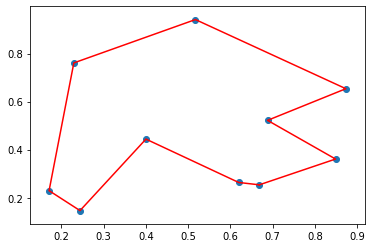

In [253]:
som_city = SOM((10, 2), cities_data)
trained_weights_cities = som_city.train_network(20, 0.2, 'tour')
final_tour = []
reordered_cities = som_city.find_reordered_cities(trained_weights_cities, cities_data)
reordered_cities = reordered_cities[:, 1].tolist()
for n in reordered_cities:
    final_tour.append(cities_data[n])

final_tour.append(final_tour[0])
final_tour = np.array(final_tour)
#print(final_tour)
plt.scatter(cities_data[:, 0], cities_data[:, 1])
plt.plot(final_tour[:, 0], final_tour[:, 1], color = 'red')


### Vote of MPs

In [3]:
#MP data
votes_data = np.loadtxt("data_lab2/votes.dat", dtype=float, delimiter=',')
mp_names = np.loadtxt("data_lab2/mpnames.txt", dtype = str, delimiter = '\n') #names of 349 MPs
votes_data = np.reshape(votes_data, (349, 31))
mp_district = np.loadtxt("data_lab2/mpdistrict.dat", dtype = 'i')
mp_sex = np.loadtxt("data_lab2/mpsex.dat", dtype = 'i', comments = '%')
mp_party = np.loadtxt("data_lab2/mpparty.dat", dtype = 'i', comments = '%')

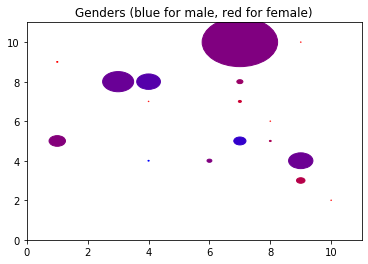

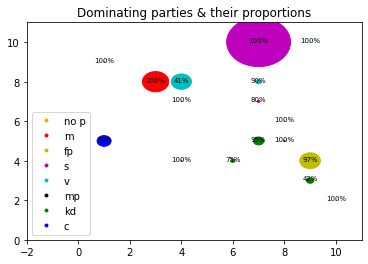

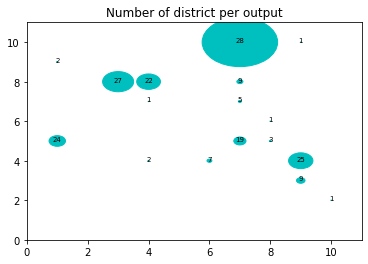

In [5]:
som_mps = SOM((100,31), votes_data)
trained_weights_mps = som_mps.train_network(50, 0.2, 'votes')
som_mps.find_reordered_mps_with_disricts_sex_party(trained_weights_mps, votes_data, mp_sex, mp_district, mp_party)